# Microgrid sizing experiments for the “convex usage dependent cost” article

**TODOs**:
- penalized approach

Pierre Haessig, Oct-November 2024

In [1]:
using Microgrids

# Optimization
using JuMP
using HiGHS # Linear Programming solver

# Display
using Printf # pretty print results
using PyPlot

# Save results
using CSV, DataFrames

Check version of Microgrids.jl (v0.11.0 needed)

In [2]:
import Pkg
Pkg.status("Microgrids")

Status `~/.julia/environments/v1.11/Project.toml`
  [bd581358] Microgrids v0.11.0


Empty DataFrames to store paramters and results, to be contructed [Row by Row](https://dataframes.juliadata.org/stable/man/getting_started/#Constructing-Row-by-Row) with `push!`

In [3]:
# Empty DataFrames
df_params = DataFrame( # experiment parameters
    case=String[],
    shed_max=Float64[],
    fuel_price=Float64[],
    sto_lifetime_cycles=Float64[], sto_lifetime_calendar=Float64[],
    fixed_lifetimes=Bool[], gen_hours_assum=Float64[],
    n_ztan=Int[], relax_gain=Float64[],
    usage_penal=Int[]
)

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain,usage_penal
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64,Int64


In [4]:
df_results_blank() = DataFrame( # results
    lcoe_pwl=Float64[], lcoe_cvx=Float64[], lcoe_ns=Float64[],
    sto_cycles=Float64[], sto_cycles_lifetime=Float64[],
    gen_hours=Float64[], gen_hours_lin=Float64[],
    xopt_gen=Float64[], xopt_sto=Float64[], xopt_pv=Float64[], xopt_wind=Float64[],
    topt=Float64[]
)
df_results_blank()

Row,lcoe_pwl,lcoe_cvx,lcoe_ns,sto_cycles,sto_cycles_lifetime,gen_hours,gen_hours_lin,xopt_gen,xopt_sto,xopt_pv,xopt_wind,topt
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


## Problem setup

In [5]:
include("./example/Microgrid_Wind-Solar_data.jl");

Base Wind-Solar Microgrid project definition functions...


In [6]:
include("./Microgrid_JuMP_common.jl");

Microgrid optimization with JuMP common functions:
- CRF
- ts_reduction
- g_tan
- cons_Xann_usage!
- build_optim_mg_stage!
- setup_optim_mg_jump
- diagnostics_mg_jump
- optim_mg_jump
- simulate_alg


In [7]:
const tseries = load_microgrid_tseries();

loading times series from data/Ouessant_data_2016.csv...


In [8]:
"""Create a Microgrid project description of size `x`

x should be [
    power_rated_gen,
    energy_rated_sto,
    power_rated_pv,
    power_rated_wind
] (in kW or kWh)

Apart from the sizing, the project is based on parameters
defined by the function `create_mg_base` which
defaults to the globally defined `create_mg_base`.
This allows modifying some project parameters.
"""
function create_microgrid(x; create_mg_base=create_mg_base)
    # Create base microgrid
    mg = create_mg_base()

    # force ConsistentSalvage, necessary for comparison with LP approaches
    mg.project.salvage_type = ConsistentSalvage

    # Set the size
    mg.generator.power_rated = x[1] # power_rated_gen
    mg.storage.energy_rated = x[2] # energy_rated_sto
    mg.nondispatchables[1].power_rated = x[3] # power_rated_pv
    mg.nondispatchables[2].power_rated = x[4] # power_rated_wind

    return mg
end

nxopt = 4 # number of optimization variables
x_base = [1000. 1000. 1000. 1000.]
mg_base = create_microgrid(x_base)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€", ConsistentSalvage), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(1000.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(1000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(1000.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float64}(1000.0, [0.03184904690521816, 0.1104932647748532, 0.24596484619739856, 0.44422012231738006, 0.6554128208926687, 0.8470913237698507, 0.9579413031865969, 0.9735278942424532, 0.9837469734016646, 0.9903667231838823  …  0.011233045262998936, 0.018460507449516883, 0.023644167600765466, 0.02969747711584798, 0.036359043012900244, 0.03713796382151399,

### Sizing bounds for each component

In [9]:
Pload_max = maximum(tseries.Pload) # kW
@printf("Max load power: %.1f kW", Pload_max)
power_rated_gen_max = 1.2 * Pload_max
energy_rated_sto_max = 10.0 * Pload_max
power_rated_pv_max = 10.0 * Pload_max
power_rated_wind_max = 5.0 * Pload_max;

Max load power: 1707.0 kW

## Algebraic approach with usage dependent cost

### Model options

Load shedding (unserved load) bound, as a fraction of cumulated desired load energy:

In [10]:
shed_max = 0.0 # in [0,1]

0.0

Choose between fixed lifetimes (gen and storage) vs usage-dependant:

In [11]:
fixed_lifetimes = false

false

assumed generator operation hours (used only if `fixed_lifetimes = true`)

In [12]:
gen_hours_assum = 2000. # in 0 – 8760 h/y

2000.0

else, use a relaxation gain to try to compensate the underestimation of e.g. the generator operating hours due to linearization. Default is 1.0. Use higher gain for stronger generator usage penalty.
- 2.0 is used for article

In [13]:
relax_gain = 2.0 # ≥ 1

2.0

### Test case options

test case modification functions

In [14]:
"""Modify Microgrid project by *multiplying* base price values:
- `sto`: `mg.storage.investment_price` 
- `gen`: `mg.generator.investment_price` 
- `fuel`: `mg.generator.fuel_price`
"""
function modify_mg_prices(;sto=1.0, gen=1.0, fuel=1.0)
    println("mg prices modifications: sto*=$sto, gen*=$gen, fuel*=$fuel")
    function modify_mg(mg)
        mg.storage.investment_price *= sto
        mg.generator.investment_price *= gen
        mg.generator.fuel_price *= fuel
        return mg # return mg to allow chaining
    end
    return modify_mg
end

"""Modify Microgrid project by *setting* storage lifetimes:
- `cal`: `mg.storage.lifetime_calendar` (years)
- `cyc`: `mg.storage.lifetime_cycles` (nb cycles)
"""
function modify_mg_lifetimes(;cal=nothing, cyc=nothing)
    cal_mod = cal !== nothing ? "cal=$cal y" : "cal unchanged"
    cyc_mod = cyc !== nothing ? "cyc=$cyc c" : "cyc unchanged"
    println("mg lifetime modification: $cal_mod, $cyc_mod")
    function modify_mg(mg)
        if cal !== nothing
            mg.storage.lifetime_calendar = cal
        end
        if cyc !== nothing
            mg.storage.lifetime_cycles = cyc
        end
        return mg # return mg to allow chaining
    end
    return modify_mg
end

modify_mg_lifetimes

Choice of base case: (using function composition `create_mg_base` → `modify_mg1` → ...)

In [15]:
create_mg_modified = modify_mg_lifetimes(cyc=1500) ∘
                     modify_mg_prices(fuel=2.0) ∘
                     create_mg_base;

mg lifetime modification: cal unchanged, cyc=1500 c
mg prices modifications: sto*=1.0, gen*=1.0, fuel*=2.0


### Algebraic model definition



#### Core model definition

Test `setup_optim_mg_jump` function to get JuMP model. Notice that this is not used later, because `setup_optim_mg_jump` is used internally by `optim_mg_jump`.

In [16]:
optimizer = HiGHS.Optimizer

mg_base, model_data = setup_optim_mg_jump(optimizer; shed_max, create_mg_base=create_mg_modified)

model_data["model"]

Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=1.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]


A JuMP Model
├ solver: HiGHS
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 78849
├ num_constraints: 140198
│ ├ AffExpr in MOI.EqualTo{Float64}: 43803
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8782
│ ├ AffExpr in MOI.LessThan{Float64}: 43801
│ ├ VariableRef in MOI.EqualTo{Float64}: 8760
│ ├ VariableRef in MOI.GreaterThan{Float64}: 35048
│ └ VariableRef in MOI.LessThan{Float64}: 4
└ Names registered in the model: none

Remarks on model size:

- stage problem has 78 849 variables (9*8760 + 9)

### Base Algebraic optim

Base case: for battery cycle life=1500 and fuel*=2 and 10 cost tangents and relax_gain=1 and 10 tangents.

Takes about 10-20s

In [17]:
optimizer = HiGHS.Optimizer

xopt_base, lcoe_base, diag_base, traj_base, md_base, mgopt_base = optim_mg_jump(optimizer;
    shed_max,
    #ndays=10,
    relax_gain,
    z_tan=[0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
    create_mg_base = create_mg_modified,
)
@printf("LCOE: %.6f €/MWh", lcoe_base*1000)

Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 11.189614 seconds (3.04 M allocations: 187.037 MiB, 0.37% gc time, 4.12% compilation time: 90% of which was recompilation)
LCOE: 250.239373 €/MWh

In [18]:
round.(xopt_base; digits=1) # optimal sizing

4-element Vector{Float64}:
 1255.5
 5837.3
 2329.5
 1596.1

#### Expected results

for battery cycle life=1500, fuel*=2, 10 tangents and relax_gain=2

LCOE: `250.239 373` €/MWh

Sizing $x^*$:
```
 Gen  1255.5
 Sto  5837.3
 PV   2329.5
 Wind 1596.1
```

same,  but with **relax_gain=1**

LCOE: `243.023 740` €/MWh

Sizing $x^*$:
```
 Gen  1216.0
 Sto  4987.9
 PV   2132.0
 Wind 1575.9
```

In [19]:
"pretty-print NamedTuple or Dict"
function pprint(d, title=nothing)
    if title !== nothing
        println("$title:")
    end
    for k in keys(d)
        println("- $k: ", d[k])
    end
end

pprint(diag_base.generator, "Generator diagnostics")
println()
pprint(diag_base.storage, "Storage diagnostics")

Generator diagnostics:
- cost_share: 0.3449048222208222
- cost_share_fuel: 0.2814672373469457
- energy: 994146.0936787404
- load_share: 0.14673788563458876
- hours: 1809.0
- hours_lin: 1583.7121724658198
- lifetime: 8.291873963515755
- lifetime_hlin: 9.471418014452203
- CRF: 0.150271578062569
- CRF_hlin: 0.1351175173783697
- CRF_hlin_pwl: 0.13497830538014102

Storage diagnostics:
- cost_share: 0.1826803559394787
- energy_through: 1.6386143945716284e6
- load_share: 0.12093132647139042
- cycles: 140.35660110762856
- lifetime_cycles: 10.687064150618514
- lifetime: 10.687064150618514
- CRF: 0.12305413939425353
- CRF_pwl: 0.12301959130765426


#### Comparison with exact costs

1. exact nonlinear cvx cost (no PWL approx, but still using the linearized operation hours)
2. exact nonsmooth cost

In [20]:
_, stats, costs_base_cvx = simulate_alg(mgopt_base, md_base,
                                        Smoothing(transition=1.0, gain=relax_gain))
costs_base_cvx.lcoe, lcoe_base, lcoe_base/costs_base_cvx.lcoe-1

(0.2502601106039112, 0.2502393733938677, -8.286262638279585e-5)

In [21]:
_, stats, costs_base_ns  = simulate_alg(mgopt_base, md_base,
                                        NoSmoothing)
costs_base_ns.lcoe, lcoe_base, lcoe_base/costs_base_ns.lcoe-1

(0.2522183390570628, 0.2502393733938677, -0.00784624016871105)

Store base case params in global experiment DataFrame `df_params`
- a first one with `relax_gain=1.0`
- a second one with `relax_gain` base value (`2.0`)

In [22]:
p = (;
    case="Base case, rgain="*string(relax_gain),
    shed_max,
    fuel_price=mgopt_base.generator.fuel_price,
    sto_lifetime_cycles=mgopt_base.storage.lifetime_cycles,
    sto_lifetime_calendar=mgopt_base.storage.lifetime_calendar,
    fixed_lifetimes=false, gen_hours_assum=NaN,
    n_ztan=10, relax_gain,
    usage_penal=0, # no usage penalty
    )
# Params with forced relax_gain=1.0
push!(df_params, p)
df_params[end, "case"] = "Base case, rgain=1.0"
df_params[end, "relax_gain"] = 1.0

# Base relax_gain
push!(df_params, p)

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain,usage_penal
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64,Int64
1,"Base case, rgain=1.0",0.0,2.0,1500.0,15.0,false,NaN,10,1.0,0
2,"Base case, rgain=2.0",0.0,2.0,1500.0,15.0,false,NaN,10,2.0,0


### Effect of PWL approximation


Experiment design: from 2 tangents to 10

In [27]:
z_tan_list = [
    [], # 2 tangents 
    [0.50], # 3
    [0.28, 0.5, 1.0], # 5
    [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0] # 10
    ]
n_ztan = length(z_tan_list)

4

In [29]:
xopt_tab_pwl = zeros(n_ztan, nxopt)
lcoe_tab_pwl = zeros(n_ztan,2) # 1) model, 2) exact nonlinear cvx

for i in 1:n_ztan
    z_tan = z_tan_list[i]
    println("Optimization with $(length(z_tan)) tangents")
    xopt, lcoe_opt, diagnostics, traj, model_data, mg_opt = optim_mg_jump(optimizer;
        shed_max,
        #ndays=50,
        fixed_lifetimes=false,
        relax_gain,
        z_tan,
        create_mg_base = create_mg_modified,
        #model_custom
    )
    # recompute exact nonlinear cvx (but still smoothed/relaxed) cost (FAILS if ndays<365!)
    _, stats, costs = simulate_alg(mg_opt, model_data,
                                   Smoothing(transition=1.0, gain=relax_gain))
    # store results
    xopt_tab_pwl[i,:] = xopt'
    lcoe_tab_pwl[i,1] = lcoe_opt
    lcoe_tab_pwl[i,2] = costs.lcoe

    # Compute z variables to understand the relation with z_tan
    log1pi = log(1+mg_base.project.discount_rate)
    Tgen_hlin = diagnostics.generator.lifetime_hlin
    z_gen = 1/Tgen_hlin/log1pi
    T_sto_cycles = diagnostics.storage.lifetime_cycles
    z_sto = 1/T_sto_cycles/log1pi
    
    println("z=1/(T.log(1+i)):")
    println("- z_gen = $z_gen (lifetime $Tgen_hlin y)")
    println("- z_sto = $z_sto (lifetime $T_sto_cycles y)")
end

lcoe_tab_pwl

Optimization with 0 tangents
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=Any[]
  9.746149 seconds (1.65 M allocations: 117.637 MiB, 0.62% gc time)
z=1/(T.log(1+i)):
- z_gen = 2.1083205115443637 (lifetime 9.72145089044094 y)
- z_sto = 1.864833974798723 (lifetime 10.990755526373354 y)
Optimization with 1 tangents
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=Any[0.5]
 10.248159 seconds (1.65 M allocations: 117.639 MiB, 3.49% gc time)
z=1/(T.log(1+i)):
- z_gen = 2.108320511544363 (lifetime 9.721450890440945 y)
- z_sto = 1.8648339747987246 (lifetime 10.990755526373343 y)
Optimization with 3 tangents
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=Any[0.28, 0.5, 1.0]
  9.9119

4×2 Matrix{Float64}:
 0.249423  0.250284
 0.249423  0.250284
 0.249601  0.250268
 0.250239  0.25026

In [30]:
xopt_tab_pwl

4×4 Matrix{Float64}:
 1246.01  6231.3   2371.4   1594.56
 1246.01  6231.3   2371.4   1594.56
 1254.02  5899.52  2368.49  1588.12
 1255.46  5837.33  2329.52  1596.12

Plot effect of nb of tangent on both LCOE. When ntan grows:
- model (pwl approx) LCOE increases
- but actual LCOE slighly decrease (since it's better approximated)!

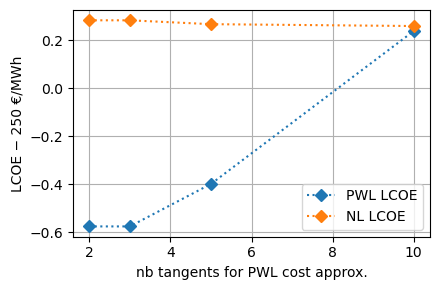

In [31]:
fig, ax = subplots(figsize=(4.5,3))
l = ax.plot([length(z_tan)+2 for z_tan in z_tan_list],
        lcoe_tab_pwl*1000 .- 250, "D:")
ax.grid(true)
ax.set(
    xlabel = "nb tangents for PWL cost approx.",
    ylabel = "LCOE − 250 €/MWh"
)
ax.legend(("PWL LCOE", "NL LCOE"))
fig.tight_layout();

Store tangent number variants params in global experiment DataFrame `df_params`

In [33]:
p = (;
    case="Less tangents",
    shed_max,
    fuel_price=mgopt_base.generator.fuel_price,
    sto_lifetime_cycles=mgopt_base.storage.lifetime_cycles,
    sto_lifetime_calendar=mgopt_base.storage.lifetime_calendar,
    fixed_lifetimes=false, gen_hours_assum=NaN,
    n_ztan=-1, relax_gain,
    usage_penal=0, # no usage penalty
    )
for n_ztan in [2,3,5]
    push!(df_params, p)
    df_params[end,"case"] = "Less tangents, n_ztan=$n_ztan"
    df_params[end,"n_ztan"] = n_ztan
end
df_params[end-2:end,:]

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64
1,"Less tangents, n_ztan=2",0.0,2.0,1500.0,15.0,false,NaN,2,2.0
2,"Less tangents, n_ztan=3",0.0,2.0,1500.0,15.0,false,NaN,3,2.0
3,"Less tangents, n_ztan=5",0.0,2.0,1500.0,15.0,false,NaN,5,2.0


### Iterative approach to set relax_gain

The goal is to adjust the operating hours relaxation gain so as to imitate the true operating hours.

We have the true number of operating hours

$$ h_{oper} = \sum_k (P(k)>0) \Delta_t = \lVert P \rVert_0 . \Delta_t$$

and the linearized number of operating hours:

$$ \tilde{h}_{oper} =  \frac{\alpha}{P^{rated}} \sum_k P(k) \Delta_t 
                   = \alpha \frac{\lVert P \rVert_1 }{P^{rated}} \Delta_t$$


therefore, the true value for $\alpha$ to get the equaliy $ h_{oper} = \tilde{h}_{oper}$ is:

$$ \alpha = \frac{ \lVert P \rVert_0.P^{rated} }{ \lVert P \rVert_1  } $$

which can be interpreted as the inverse capacity factor when the generator is on. It is of course not possible to know this gain value beforehand. However, we use the a posteriori results one optimization run to set the gain for the next one, which yield the following update:

$$ \alpha^{(i+1)} =  \alpha^{(i)}  \frac{ h_{oper}^{(i)} }{ \tilde{h}_{oper}^{(i)} } $$

Put another way, with get that $\tilde{h}_{oper}^{(i+1)} = \alpha^{(i+1)}\frac{\lVert P \rVert_1^{(i+1)} }{P^{rated}} \Delta_t $ is in fact:

$$ \tilde{h}_{oper}^{(i+1)} = \frac{ \lVert P \rVert_0^{(i)} }{ \lVert P \rVert_1^{(i)} } \lVert P \rVert_1^{(i+1)} $$

and with some optional smoothing $\theta \in [0,1[$, the relaxation gain update can become:

$$ \alpha^{(i+1)} =  \theta \alpha^{(i)} + (1-\theta) \alpha^{(i)}  \frac{ h_{oper}^{(i)} }{ \tilde{h}_{oper}^{(i)} } $$



In [34]:
"""Optimize sizing of microgrid using JuMP: iteration `relax_gain`

and extract results

# Parameters
- same as `optim_mg_jump`, except that
- `fixed_lifetimes=false` is assumed, so `gen_hours_assum` is not needed
- `relax_gain_start` replaces `relax_gain`
- `relax_gain_smoothing` in [0, 1[ sets how slow relax_gain is updated. 0=no smoothing
- `n_iter`: number of iterations (default 6)

Returns:
xopt_tab, lcoe_tab, rgain_tab, diagnostics, traj, model_data

(the last ones are from the last iteration)
"""
function optim_mg_iter_relgain(optimizer;
        shed_max=0.0,
        ndays=365,
        relax_gain_start = 1.0,
        relax_gain_smoothing = 0.0,
        n_iter=6,
        z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
        create_mg_base=create_mg_base,
        model_custom=nothing,
    )

    xopt_tab = zeros(0, nxopt)
    lcoe_tab = zeros(0,3)  # 1) model, 2) exact nonlinear cvx, 3) exact nonsmooth
    rgain_tab = zeros(n_iter,1)
    relax_gain = relax_gain_start # init
    local diagnostics, traj, model_data
    
    for i in 1:n_iter
        println("relax_gain iteration $i: $relax_gain")
        rgain_tab[i] = relax_gain # store relax_gain
        xopt, lcoe_opt, diagnostics, traj, model_data, mg_opt = optim_mg_jump(optimizer;
            shed_max, ndays,
            fixed_lifetimes=false,
            relax_gain,
            z_tan,
            create_mg_base,
            model_custom
        )
        # recompute exact costs (FAILS if ndays<365!)
        _, stats, costs_cvx = simulate_alg(mg_opt, model_data,
                                           Smoothing(transition=1.0, gain=relax_gain))
        _, stats, costs_ns  = simulate_alg(mg_opt, model_data,
                                           NoSmoothing)
        
        # store results
        xopt_tab = [xopt_tab; xopt']
        lcoe_tab = [lcoe_tab;
                    lcoe_opt costs_cvx.lcoe costs_ns.lcoe]
        
        # correct next gain
        print("  hours/hours_lin: ")
        println(diagnostics.generator.hours / diagnostics.generator.hours_lin)
        relax_gain_target = relax_gain*diagnostics.generator.hours / diagnostics.generator.hours_lin
        relax_gain = relax_gain_smoothing*relax_gain + 
                     (1-relax_gain_smoothing)*relax_gain_target
    end
    
    return xopt_tab, lcoe_tab, rgain_tab, diagnostics, traj, model_data
end

optim_mg_iter_relgain

In [35]:
xopt_tab_rgain, lcoe_tab_rgain, rgain_tab, diagnostics, traj, model_data =  optim_mg_iter_relgain(optimizer;
    shed_max,
    #ndays=20,
    relax_gain_start = 1.0,
    n_iter=6,
    #z_tan=[0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
    create_mg_base=create_mg_modified,
    #model_custom=nothing
)
lcoe_tab_rgain

relax_gain iteration 1: 1.0
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=1.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 10.950931 seconds (1.65 M allocations: 117.649 MiB, 2.90% gc time, 0.03% compilation time)
  hours/hours_lin: 2.285082091467946
relax_gain iteration 2: 2.285082091467946
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.285082091467946)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
  9.460538 seconds (1.65 M allocations: 117.648 MiB, 0.33% gc time)
  hours/hours_lin: 0.9899655505490673
relax_gain iteration 3: 2.2621525507298794
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.2621525507298794)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
  9.964115 seconds (1.65 M alloc

6×3 Matrix{Float64}:
 0.243024  0.243056  0.252907
 0.252147  0.252175  0.252022
 0.251994  0.252022  0.252048
 0.252019  0.252048  0.252048
 0.252019  0.252048  0.252048
 0.252019  0.252048  0.252048

observation: at the second iteration, we get in fact a exact non smooth cost which is lower. This means the iteration is locked in a local minimum!

In [36]:
xopt_tab_rgain

6×4 Matrix{Float64}:
 1215.98  4987.93  2132.0   1575.9
 1249.59  6072.31  2384.13  1605.97
 1250.18  6046.1   2378.02  1608.66
 1250.18  6046.1   2378.02  1608.66
 1250.18  6046.1   2378.02  1608.66
 1250.18  6046.1   2378.02  1608.66

Plot the convergence with relax_gain tuning:

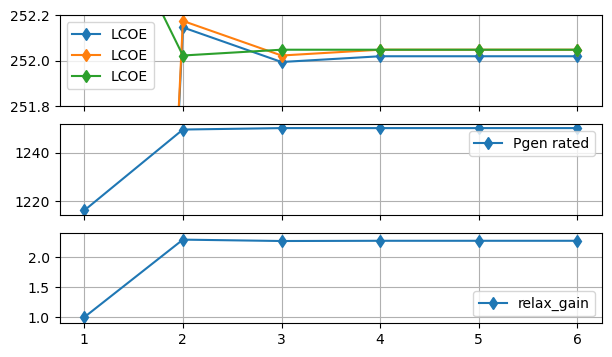

In [37]:
fig, ax = subplots(3,1, figsize=(7,4), sharex=true)

n_iter = length(rgain_tab)

ax[1].plot(1:n_iter, lcoe_tab_rgain*1000, "d-", label="LCOE")
ax[1].set_ylim(251, 253) # 365 days
ax[1].set_ylim(251.8, 252.2)


ax[2].plot(1:n_iter, xopt_tab_rgain[:,1], "d-", label="Pgen rated")
#ax[2].set_ylim(630, 670)

#ax[3].plot(2:n_iter, rgain_tab[2:end]./rgain_tab[1:end-1] .- 1,
#           "d-", label="relax_gain change")
#ax[3].set_ylim(-12e-3, +12e-3)
ax[3].plot(1:n_iter, rgain_tab,
           "d-", label="relax_gain")
ax[3].set_ylim(0.9, 2.4)

for axi in ax
    axi.grid(true)
    axi.legend()
end

Store case with last relaxation gain

In [38]:
rgain_tab[end]

2.2659846854120627

In [39]:
p = (;
    case="Relax gain convergence",
    shed_max,
    fuel_price=mgopt_base.generator.fuel_price,
    sto_lifetime_cycles=mgopt_base.storage.lifetime_cycles,
    sto_lifetime_calendar=mgopt_base.storage.lifetime_calendar,
    fixed_lifetimes=false, gen_hours_assum=NaN,
    n_ztan=10, relax_gain=rgain_tab[end],
    usage_penal=0, # no usage penalty
    )
push!(df_params, p)   
df_params[end,:]

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64
6,Relax gain convergence,0.0,2.0,1500.0,15.0,false,NaN,10,2.26598


## Fixed lifetime approach

Fixed lifetime variants:
- “Round and reasonable” estimates:
    - 2000 h/y for generator
    - 10 years calendar lifetime for storage
- ”Matching baseline” (baseline being relax_gain=2):
    - 1809 h/y for generator
    - 10.687 years calendar lifetime for storage
- “15 years storage”, i.e. too optimistic lifetime:
    - 2000 h/y for generator
    - 15 years calendar lifetime for storage


**Optimization time** is reduced by about 55% to ~5s

In [40]:
# Change storage calendar lifetime
create_mg_modified_stocal = modify_mg_lifetimes(cal=10) ∘ create_mg_modified

x_fxlt, lcoe_fxlt, diag_fxlt, traj_fxlt, md_fxlt, mg_fxlt = optim_mg_jump(optimizer;
    shed_max,
    fixed_lifetimes = true,
    gen_hours_assum = 2000.,
    relax_gain,
    create_mg_base = create_mg_modified_stocal,
)
@printf("LCOE: %.9f €/MWh (wrong)", lcoe_fxlt*1000)

mg lifetime modification: cal=10 y, cyc unchanged
Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 7.5 y, assuming 2000.0  h/y of usage
  4.676179 seconds (1.64 M allocations: 115.996 MiB, 8.15% gc time)
LCOE: 248.752130296 €/MWh (wrong)

Comparison with exact cost (only nonsmooth cost makes sense here):

In [42]:
_, stats_fxlt, costs_fxlt_ns  = simulate_alg(mg_fxlt, md_fxlt, NoSmoothing)
costs_fxlt_ns.lcoe, lcoe_fxlt, lcoe_fxlt/costs_fxlt_ns.lcoe-1

(0.25619548748296184, 0.2487521302962008, -0.029053428145396354)

Sizing with fixed lifetime vs base sizing

In [43]:
round.([x_fxlt xopt_base]; digits=1) # optimal sizing

4×2 Matrix{Float64}:
 1186.4  1255.5
 3495.2  5837.3
 2198.2  2329.5
 1484.5  1596.1

### Analyses

For “Round and reasonable” estimates (2000 h/y gen, 10 y sto):
- LCOE:
    - 256.195 €/MWh (exact nonsmooth)
    - 248.752 €/MWh (model) → 2.9% cost underestimation
- Gen ends up at 2495 h/y (+25% to assumption). 1186.4 kW
- Sto ends up at 8.44 y (-16% to assumption). 3495.2 kWh

For ”Matching baseline” (1809 h/y gen, 10.687 y sto)
- LCOE:
    - 255.241 €/MWh (exact nonsmooth)
    - 245.989 €/MWh (model) → -3.6% cost underestimation
- Gen ends up at 2403 h/y (+33% to assumption). 1169.7 kW
- Sto ends up at 8.63 y (-19% to assumption). 3823.3 kWh
- → Ccl: matching the `relax_gain = 2` baseline is a **failure** (no self consistency)

For “Too optimistic” 15 years lifetime storage assumption, i.e. too optimistic (2000 h/y gen, 15 y sto):
- LCOE:
    - 253.072 €/MWh (exact nonsmooth)
    - 241.537 €/MWh (model) → -4.6% cost underestimation
- Gen ends up at 2060 h/y (+3%, i.e. quite close to assumption). 1128.9 kW
- Sto ends up at 9.01 y (**-40%** to assumption). 4840.5 kWh
- *Remark: result is quite similar with 3000 h/y gen assumption (→ actual hours at 2021 h/y)*
- Oddly enough, starting from a worse lifetime assumption, we get a better exact LCOE!

In [44]:
pprint(diag_fxlt.generator, "Generator diagnostics")
println()
pprint(diag_fxlt.storage, "Storage diagnostics")

Generator diagnostics:
- cost_share: 0.44128149872185646
- cost_share_fuel: 0.36717969527686845
- energy: 1.2891759107806042e6
- load_share: 0.19028485708673107
- hours: 2495.0
- hours_lin: 2173.301254696729
- lifetime: 6.012024048096192
- lifetime_hlin: 6.901942364218236
- CRF: 0.19667830314269383
- CRF_hlin: 0.17487993325252757
- CRF_hlin_pwl: 0.16316086288079687

Storage diagnostics:
- cost_share: 0.11474586817761262
- energy_through: 1.2422988748374572e6
- load_share: 0.09168285797177063
- cycles: 177.71262006608205
- lifetime_cycles: 8.440593579916992
- lifetime: 8.440593579916992
- CRF: 0.14812395040600537
- CRF_pwl: 0.12950457496545661


Store fixed lifetime variants in global experiment DataFrame `df_params`

In [45]:
fixed_lifetime_variants = [
    (2000., 10.,    "round & reasonable"),
    (1809., 10.687, "matching rgain=2"),
    (2000., 15.,    "optimistic 15y"),
    (2760.0, 7.877, "convergence") # see section below
]
p = (;
    case="Fixed lifetime, ",
    shed_max,
    fuel_price=mgopt_base.generator.fuel_price,
    sto_lifetime_cycles=mgopt_base.storage.lifetime_cycles,
    sto_lifetime_calendar=NaN,
    fixed_lifetimes=true, gen_hours_assum=NaN,
    n_ztan=0, relax_gain=NaN, # ztan and relaxation are inactive
    usage_penal=0, # no usage penalty
    )
for (gen_hours_assum, sto_lifetime_calendar, name) in fixed_lifetime_variants
    push!(df_params, p)
    df_params[end,"case"] *= name
    df_params[end,"gen_hours_assum"] = gen_hours_assum
    df_params[end,"sto_lifetime_calendar"] = sto_lifetime_calendar
end
df_params[end-3:end,:]

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64
1,"Fixed lifetime, round & reasonable",0.0,2.0,1500.0,10.0,true,2000.0,0,NaN
2,"Fixed lifetime, matching rgain=2",0.0,2.0,1500.0,10.687,true,1809.0,0,NaN
3,"Fixed lifetime, optimistic 15y",0.0,2.0,1500.0,15.0,true,2000.0,0,NaN
4,"Fixed lifetime, convergence",0.0,2.0,1500.0,7.877,true,2760.0,0,NaN


### Iterative lifetime adjustment

- Starting from “Round and reasonable” estimates (2000 h/y gen, 10 y sto)
- Starting from “too optimistic” estimates (2000 h/y gen, 15 y sto)
    - same if starting from (**3000** h/y gen, 15 y sto)

→ all three converge to 2760.0  h/y and 7.877 y sto in 6 iter or less.

Final LCOE is **259.502 €/MWh**
- perfect match between exact and model
- but quite bad (all other LCOEs are about 252 - 253 €/MWh)

In [46]:
"""Optimize sizing of microgrid using JuMP: iteration of assumed fixed lifetimes

and extract results

# Parameters
- same as `optim_mg_jump`, except that
- `fixed_lifetimes=true` is assumed, so `gen_hours_assum` is not needed
- `gen_hours_assum_start` replaces `gen_hours_assum`
- `lifetimes_smoothing` in [0, 1[ sets how slow lifetimes are updated. 0=no smoothing
- `n_iter`: number of iterations (default 10)

remark: initial sto_lifetime_calendar is taken from the base mg

Returns:
xopt_tab, lcoe_tab, gen_hours_assum_tab, sto_lifetime_calendar_tab,
diagnostics, traj, model_data

(the last ones are from the last iteration)
"""
function optim_mg_iter_lifetimes(optimizer;
        shed_max=0.0,
        ndays=365,
        gen_hours_assum_start = 2000,
        lifetimes_smoothing = 0.0,
        n_iter=10,
        create_mg_base=create_mg_base,
        model_custom=nothing,
    )

    xopt_tab = zeros(0, nxopt)
    lcoe_tab = zeros(0,2)  # 1) model, 2) exact nonsmooth (no cvx cost)
    gen_hours_assum_tab = zeros(n_iter,1)
    sto_lifetime_calendar_tab = zeros(n_iter,1)
    # Init
    gen_hours_assum = gen_hours_assum_start # init
    create_mg_base_iter = create_mg_base
    sto_lifetime_calendar = create_mg_base_iter().storage.lifetime_calendar
    local diagnostics, traj, model_data
    
    for i in 1:n_iter
        println("fixed lifetimes iteration $i: gen $gen_hours_assum h/y, sto $sto_lifetime_calendar y")
        # store lifetime parameters
        gen_hours_assum_tab[i] = gen_hours_assum
        sto_lifetime_calendar_tab[i] = sto_lifetime_calendar
        xopt, lcoe_opt, diagnostics, traj, model_data, mg_opt = optim_mg_jump(optimizer;
            shed_max, ndays,
            fixed_lifetimes=true,
            gen_hours_assum,
            relax_gain=0, # set to 0 to since it should have no effect
            create_mg_base = create_mg_base_iter,
            model_custom
        )
        # recompute exact costs (FAILS if ndays<365!). Only nonsmooth costs
        _, stats, costs_ns  = simulate_alg(mg_opt, model_data, NoSmoothing)
        
        # store results
        xopt_tab = [xopt_tab; xopt']
        lcoe_tab = [lcoe_tab;
                    lcoe_opt costs_ns.lcoe]
        
        # correct next lifetimes
        print("  gen hours/assumed: ")
        println(diagnostics.generator.hours / gen_hours_assum)
        gen_hours_assum = lifetimes_smoothing*gen_hours_assum +
                          (1-lifetimes_smoothing)*diagnostics.generator.hours
        print("  sto lifetime/assumed: ")
        println(diagnostics.storage.lifetime_cycles / sto_lifetime_calendar)
        sto_lifetime_calendar = lifetimes_smoothing*sto_lifetime_calendar +
                                (1-lifetimes_smoothing)*diagnostics.storage.lifetime_cycles
        create_mg_base_iter =  modify_mg_lifetimes(cal=sto_lifetime_calendar) ∘ create_mg_base
    end
    
    return xopt_tab, lcoe_tab, gen_hours_assum_tab, sto_lifetime_calendar_tab,
           diagnostics, traj, model_data
end

optim_mg_iter_lifetimes

In [47]:
create_mg_modified_stocal = modify_mg_lifetimes(cal=10) ∘ create_mg_modified

xopt_tab_fxlt, lcoe_tab_fxlt, gen_hours_assum_tab, sto_lifetime_calendar_tab, 
diagnostics, traj, model_data =  optim_mg_iter_lifetimes(optimizer;
    shed_max,
    gen_hours_assum_start = 2000,
    n_iter = 6,
    create_mg_base=create_mg_modified_stocal,
)
lcoe_tab_fxlt

mg lifetime modification: cal=10 y, cyc unchanged
fixed lifetimes iteration 1: gen 2000 h/y, sto 10.0 y
Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 7.5 y, assuming 2000  h/y of usage
  4.654486 seconds (1.64 M allocations: 115.996 MiB, 0.96% gc time)
  gen hours/assumed: 1.2475
  sto lifetime/assumed: 0.8440593579916993
mg lifetime modification: cal=8.440593579916992 y, cyc unchanged
fixed lifetimes iteration 2: gen 2495.0 h/y, sto 8.440593579916992 y
Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 6.012024048096192 y, assuming 2495.0  h/y of usage
  4.436282 seconds (1.64 M allocations: 115.996 MiB, 1.81% gc time)
  gen hours/assumed: 1.0681362725450902
  sto lifetime/assumed: 0.9588033517804793
mg lifetime modification: cal=8.092869415441207 y, cyc unchanged
fixed lifetimes iteration 3: gen 2665.0 h/y, sto 8.092869415441207 y
Building stage problem with 365 days...
zero

6×2 Matrix{Float64}:
 0.248752  0.256195
 0.256002  0.25824
 0.258206  0.259448
 0.259445  0.259502
 0.259502  0.259502
 0.259502  0.259502

In [48]:
xopt_tab_fxlt

6×4 Matrix{Float64}:
 1186.38  3495.25  2198.19  1484.49
 1209.81  3036.64  2136.02  1472.57
 1223.72  2770.87  2094.33  1463.3
 1227.37  2705.76  2072.78  1477.07
 1227.37  2705.76  2072.78  1477.07
 1227.37  2705.76  2072.78  1477.07

**Observations**:
- the iterative fixed lifetimes adjustment procedure reaches steady state (like with `relax_gain` iteration)
- **but** it is different from the `relax_gain` iteration, and the LCOE is quite bad (259.502 €/MWh)

## Usage penalty approach


Model customization to penalize usage variables (instead of having the nonlinear influence of usage through annualized size)

A key question in this approach is how to value the investment, that is what should be the CRF (or the lifetime value used for CRF):
- in the literature, people tends to use the project lifetime. If project lifetime is large, then $CRF \approx i$
- our linearization of the annualized cost, which shows that, in high usage regime, it would be better to use $CRF \approx i/2$
    -  this requires rewriting the investment cost constraint (based on annualized size)

here we use both approaches

Note that for the generator, setting the generator lifetime is a bit more difficult to implement, since it is controled by `gen_hours_assum` which also impacts O&M cost.

In [49]:
CRF(0.05, mgopt_base.storage.lifetime_calendar), # 15y: 0.096
CRF(0.05, mgopt_base.project.lifetime), # 25y: 0.070
CRF(0.05, 100) # T→inf: 0.050

(0.09634228760924432, 0.0709524572992296, 0.05038313806951108)

In [51]:
md_base["cons_Esto_rated_ann_CRFsto_cal"] # CRF=0.096 for 15y

-0.09634228760924432 energy_rated_sto + Esto_rated_ann ≥ 0

### Model customizations

Customization to add usage penalty

In [28]:
"""Penalize generator and storage usage in Cann
"""
function model_penalize_usage(md, mg)
    relax_gain = md["relax_gain"]
    println("Penalized usage variant (relax_gain=", relax_gain,")")
    model = md["model"]

    # Add usage variables (not added when fixed_lifetimes=true)
    # Generator usage:
    @assert "Ugen" ∉ keys(md) "Ugen shouldn't have been defined. Make sure fixed_lifetimes=true"
    md["Ugen"] = @variable(model, Ugen >= 0) # cumulated usage
    @constraint(model, Ugen == md["Egen"]*relax_gain/mg.generator.lifetime_hours); # kW/y
    # Storage usage
    @assert "Usto" ∉ keys(md) "Usto shouldn't have been defined. Make sure fixed_lifetimes=true"
    md["Usto"] = @variable(model, Usto >= 0) # cumulated usage
    @constraint(model, Usto == md["E_through_sto"]/(2*mg.storage.lifetime_cycles))
    
    # overwrite cost function with penalties
    md["Ugen_penal"] = Ugen_penal = mg.generator.investment_price * Ugen
    md["Usto_penal"] = Usto_penal = mg.storage.investment_price * Usto
    
    md["Cann_penal"] = Cann_penal = md["Cann"] + Ugen_penal + Usto_penal
    @objective(model, Min, Cann_penal)
end

model_penalize_usage

Customization to change generator lifetime to project lifetime (not to be used with `model_change_CRF`!)

In [29]:
"""Change generator lifetime to project lifetime
"""
function model_gen_lifetime_project(md, mg)
    println("Change generator lifetime to project lifetime")

    model = md["model"]
    # Retrieve useful variables
    Pgen_rated_ann = md["Pgen_rated_ann"]
    power_rated_gen = md["power_rated_gen"]

    # Delete Pgen_rated_ann == power_rated_gen * CRFproj(gen_lifetime)
    # (which is based on gen_hours_assum)
    delete(model, md["cons_Pgen_rated_ann_CRFgen_lifetime"])
    # Replace
    CRFproj = CRF(mg.project.discount_rate, mg.project.lifetime)
    md["cons_Pgen_rated_ann_CRFgen_lifetime"] = @constraint(model,
        Pgen_rated_ann == power_rated_gen * CRFproj)
end

model_gen_lifetime_project

Customization to change CRF for battery and generator to i/2 (not te be used with `model_gen_lifetime_project`!)

In [30]:
"""Change CRF for battery and generator to i/2
"""
function model_change_CRF(md, mg)
    discount_rate = mg.project.discount_rate
    println("Change CRF for battery and generator to i/2=", discount_rate/2)

    model = md["model"]
    # Retrieve useful variables
    Esto_rated_ann = md["Esto_rated_ann"]
    energy_rated_sto = md["energy_rated_sto"]
    Pgen_rated_ann = md["Pgen_rated_ann"]
    power_rated_gen = md["power_rated_gen"]

    # Delete Esto_rated_ann >= energy_rated_sto * CRFsto_cal
    delete(model, md["cons_Esto_rated_ann_CRFsto_cal"])
    # Replace
    md["cons_Esto_rated_ann_CRFsto_cal"] = @constraint(model,
        Esto_rated_ann >= energy_rated_sto * discount_rate/2)

    # Delete Pgen_rated_ann == power_rated_gen * CRFproj(gen_lifetime)
    # (which is based on gen_hours_assum)
    delete(model, md["cons_Pgen_rated_ann_CRFgen_lifetime"])
    # Replace
    md["cons_Pgen_rated_ann_CRFgen_lifetime"] = @constraint(model,
        Pgen_rated_ann == power_rated_gen * discount_rate/2)
end

model_change_CRF

Combinations:

In [31]:
"""Usage penalty model changes, variant 1:
- Change generator lifetime to project lifetime
- Penalize generator and storage usage in Cann
"""
function model_change_both_v1(md, mg)
    model_gen_lifetime_project(md, mg)
    model_penalize_usage(md, mg)
end

model_change_both_v1

In [32]:
"""Usage penalty model changes, variant 2:
- Change CRF for battery and generator to i/2
- Penalize generator and storage usage in Cann
"""
function model_change_both_v2(md, mg)
    model_change_CRF(md, mg)
    model_penalize_usage(md, mg)
end

model_change_both_v2

### Variant 1

generator and storage lifetimes set to project lifetime

In [61]:
create_mg_modified_stocal = modify_mg_lifetimes(cal=mgopt_base.project.lifetime) ∘ create_mg_modified

x_penal1, lcoe_penal1, diagnostics_penal1, traj_penal1, md_penal1, mg_penal1 = optim_mg_jump(optimizer;
    shed_max,
    #ndays=30,
    fixed_lifetimes=true,
    gen_hours_assum = 2000.,
    relax_gain,
    create_mg_base = create_mg_modified_stocal,
    model_custom = model_change_both_v1
)
@printf("LCOE: %.9f €/MWh (wrong: fixed lifetime)", lcoe_penal1*1000)

mg lifetime modification: cal=25 y, cyc unchanged
Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 7.5 y, assuming 2000.0  h/y of usage
Change generator lifetime to project lifetime
Penalized usage variant (relax_gain=2.0)
  6.254564 seconds (1.64 M allocations: 119.504 MiB, 6.59% gc time)
LCOE: 234.926184324 €/MWh (wrong: fixed lifetime)

Amount of penalties on the annualized cost: +9% (not counted in LCOE!)

In [28]:
md_penal1["cons_Esto_rated_ann_CRFsto_cal"]

-0.0709524572992296 energy_rated_sto + Esto_rated_ann ≥ 0

In [29]:
md_penal1["cons_Pgen_rated_ann_CRFgen_lifetime"]

-0.0709524572992296 power_rated_gen + Pgen_rated_ann = 0

In [62]:
vmd(name) = value(md_penal1[name]) # sortcut: value of JuMP variable with the model_data Dict
@printf("Cann penalty: %+.1f%% (%+.1f%% for gen, %+.1f%% for sto)",
    (vmd("Cann_penal")/vmd("Cann")-1)*100,
    vmd("Ugen_penal")/vmd("Cann")*100,
    vmd("Usto_penal")/vmd("Cann")*100
)

Cann penalty: +11.6% (+4.5% for gen, +7.1% for sto)

Annualized generator and storage sizes:

In [63]:
vmd("Pgen_rated_ann"), vmd("Esto_rated_ann")

(86.66147398707587, 199.51298135477248)

Comparison with exact cost (only nonsmooth cost makes sense here):

In [64]:
_, stats_penal1, costs_penal1_ns  = simulate_alg(mg_penal1, md_penal1, NoSmoothing)
costs_penal1_ns.lcoe, lcoe_penal1, lcoe_penal1/costs_penal1_ns.lcoe-1

(0.2578099150503256, 0.23492618432359913, -0.08876202733420646)

Check the amount of generator OM:

In [65]:
@printf("Cgen: %.1f%% of Cann (%.1f k€),\n",
    vmd("Cgen")/vmd("Cann")*100,
    vmd("Cgen")/1000
)
@printf("of which %.1f%% (%.1f k€) of OM cost (due to gen_hours_assum)",
    vmd("Cgen_om")/vmd("Cgen")*100,
    vmd("Cgen_om")/1000
)

Cgen: 46.0% of Cann (732.7 k€),
of which 6.7% (48.9 k€) of OM cost (due to gen_hours_assum)

### Variant 2

Change CRF for battery and generator to i/2 → makes them both their investment cost cheaper 

In [66]:
x_penal2, lcoe_penal2, diagnostics_penal2, traj_penal2, md_penal2 = optim_mg_jump(optimizer;
    shed_max,
    #ndays=30,
    fixed_lifetimes=true,
    gen_hours_assum = 2000.,
    relax_gain,
    create_mg_base, # no need to change calendar lifetime, since its CRF is changed to i/2 anyway
    model_custom = model_change_both_v2
)
@printf("LCOE: %.9f €/MWh (wrong: fixed lifetime)", lcoe_penal2*1000)

Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 7.5 y, assuming 2000.0  h/y of usage
Change CRF for battery and generator to i/2=0.025
Penalized usage variant (relax_gain=2.0)
  5.443852 seconds (1.64 M allocations: 119.768 MiB, 0.70% gc time)
LCOE: 168.638106653 €/MWh (wrong: fixed lifetime)

In [38]:
md_penal2["cons_Esto_rated_ann_CRFsto_cal"]

-0.025 energy_rated_sto + Esto_rated_ann ≥ 0

In [67]:
md_penal2["cons_Pgen_rated_ann_CRFgen_lifetime"]

-0.025 power_rated_gen + Pgen_rated_ann = 0

Annualized generator and storage sizes: very small

In [69]:
vmd(name) = value(md_penal2[name]) # sortcut: value of JuMP variable with the model_data Dict
vmd("Pgen_rated_ann"), vmd("Esto_rated_ann")

(31.582150375909954, 54.13382474448337)

Generator cost: smaller than in v1 in absolute sense → takes a larger share

In [73]:
@printf("Cgen: %.1f%% of Cann (%.1f k€),\n",
    vmd("Cgen")/vmd("Cann")*100,
    vmd("Cgen")/1000
)

Cgen: 44.5% of Cann (508.4 k€),


### Variants comparison

Sizing comparison (both variants) vs base sizing
- even smaller battery for v2 vs v1

In [70]:
round.([x_penal1 x_penal2 xopt_base]; digits=1) # optimal sizing

4×3 Matrix{Float64}:
 1221.4  1263.3  1255.5
 2811.9  2165.4  5837.3
 1817.2  1347.9  2329.5
 1636.0  1297.1  1596.1

Dispatch comparison:
- in v1, the generator covers 20.0% of the load
- in v2, the generator covers 27.4% of the load
    - → it seems that the cheaper battery investments gets shadowed by the cheaper generator investment...

In [71]:
pprint(diagnostics_penal1.generator, "Generator diagnostics (penalty variant 1)")

Generator diagnostics (penalty variant 1):
- cost_share: 0.46037971981965375
- cost_share_fuel: 0.4079044607572424
- energy: 1.3525601743614555e6
- load_share: 0.19964049694640462
- hours: 2653.0
- hours_lin: 2214.766576214286
- lifetime: 5.653976630229929
- lifetime_hlin: 6.772722760535601
- CRF: 0.20740033416092307
- CRF_hlin: 0.17768671111364998
- CRF_hlin_pwl: 0.0709524572992296


In [72]:
pprint(diagnostics_penal2.generator, "Generator diagnostics (penalty variant 2)")

Generator diagnostics (penalty variant 2):
- cost_share: 0.4449546786384655
- cost_share_fuel: 0.3896695885373846
- energy: 1.8550214774010058e6
- load_share: 0.2738047567971806
- hours: 3807.0
- hours_lin: 2936.819461818484
- lifetime: 3.9401103230890464
- lifetime_hlin: 5.107566261738123
- CRF: 0.2858939078166822
- CRF_hlin: 0.22668011867301127
- CRF_hlin_pwl: 0.025


Store usage penalty variants in global experiment DataFrame `df_params`

In [ ]:
p = (;
    case="Usage penalty, ",
    shed_max,
    fuel_price=mgopt_base.generator.fuel_price,
    sto_lifetime_cycles=mgopt_base.storage.lifetime_cycles,
    sto_lifetime_calendar=mgopt_base.storage.lifetime_calendar,
    fixed_lifetimes=false, gen_hours_assum=NaN,
    n_ztan=0, relax_gain,
    usage_penal=1, # with usage penalty, variant 1 or 2
    )
# Params with variant 1 (generator and storage lifetimes set to project lifetime)
# but for generator its done separately
push!(df_params, p)
df_params[end, "case"] *= "variant 1"
df_params[end, "sto_lifetime_calendar"] = mgopt_base.project.lifetime
df_params[end, "usage_penal"] = 1

# Params with variant 2 (CRF=i/2)
push!(df_params, p)
df_params[end, "case"] *= "variant 2"
df_params[end, "sto_lifetime_calendar"] = NaN
df_params[end, "usage_penal"] = 2

df_params[end-1:end,:]

### Case when storage cycle life is not active

by setting calendar lifetime to 10 year (while the optimum is 10.x years)


#### Our method:

makes the best use of those 10 years, with T_cycle = 9.99 years !

In [76]:
create_mg_modified_cal10y = modify_mg_lifetimes(cal=10) ∘ create_mg_modified

x_cal10y, lcoe_cal10y, diag_cal10y, traj_cal10y, md_cal10y = optim_mg_jump(optimizer;
    shed_max,
    relax_gain,
    create_mg_base = create_mg_modified_cal10y,
)
@printf("LCOE: %.9f €/MWh", lcoe_cal10y*1000)

mg lifetime modification: cal=10 y, cyc unchanged
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 13.272392 seconds (1.65 M allocations: 117.648 MiB, 0.18% gc time)
LCOE: 250.492323824 €/MWh

Sizing vs base sizing:
- slightly smaller battery, as one may expect

In [48]:
round.([x_cal10y xopt_base]; digits=1) # optimal sizing

4×2 Matrix{Float64}:
 1184.4  1255.5
 5131.2  5837.3
 2296.4  2329.5
 1584.0  1596.1

Observation: T_cycle = 9.99 years !

In [77]:
pprint(diag_cal10y.storage, "Storage diagnostics")

Storage diagnostics:
- cost_share: 0.16728362196577656
- energy_through: 1.5406589676988088e6
- load_share: 0.11370212126847985
- cycles: 150.1255855113518
- lifetime_cycles: 9.991634636366344
- lifetime: 9.991634636366344
- CRF: 0.12958869413255772
- CRF_pwl: 0.12950457496545661


#### Penalized usage method with 10 years calendar life

In [78]:
x_penal_cal10y, lcoe_penal_cal10y, diag_penal_cal10y, traj_penal_cal10y, md_penal_cal10y = optim_mg_jump(optimizer;
    shed_max,
    #ndays=30,
    fixed_lifetimes=true,
    gen_hours_assum = 2000.,
    relax_gain,
    create_mg_base = create_mg_modified_cal10y,
    model_custom = model_penalize_usage # SMALL bug: generator lifetime not changed
)
@printf("LCOE: %.9f €/MWh (wrong: fixed lifetime)", lcoe_penal_cal10y*1000)

Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 7.5 y, assuming 2000.0  h/y of usage
Penalized usage variant (relax_gain=2.0)
  5.723440 seconds (1.64 M allocations: 117.502 MiB, 1.08% gc time)
LCOE: 254.340344832 €/MWh (wrong: fixed lifetime)

Sizing comparison:
- as expected, the penalized approach with short calendar liftime yields an even smaller battery

In [80]:
round.([x_penal_cal10y x_penal1 x_cal10y]; digits=1) # optimal sizing

4×3 Matrix{Float64}:
 1328.4  1221.4  1184.4
  944.7  2811.9  5131.2
 1545.2  1817.2  2296.4
 1687.1  1636.0  1584.0

--- 

## Rerun all experiments

Experiments parameters saved in `df_params`:

In [26]:
df_params

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain,usage_penal
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64,Int64
1,"Base case, rgain=1.0",0.0,2.0,1500.0,15.0,false,NaN,10,1.0,0
2,"Base case, rgain=2.0",0.0,2.0,1500.0,15.0,false,NaN,10,2.0,0
3,"Usage penalty, variant 1",0.0,2.0,1500.0,25.0,false,NaN,0,2.0,1
4,"Usage penalty, variant 2",0.0,2.0,1500.0,NaN,false,NaN,0,2.0,2


In [27]:
df_results = df_results_blank()
for (i, row) in enumerate(eachrow(df_params))
    println("---")
    println("Processing case ", i, " :", row.case)
    
    create_mg_iter = modify_mg_prices(fuel=row.fuel_price) ∘
        modify_mg_lifetimes(cyc=row.sto_lifetime_cycles, cal=row.sto_lifetime_calendar) ∘
        create_mg_base

    if row.n_ztan == 2 || row.n_ztan == 0
        z_tan_iter = []
    elseif row.n_ztan == 3
        z_tan_iter = [0.50]
    elseif row.n_ztan == 5
        z_tan_iter = [0.28, 0.5, 1.0]
    elseif row.n_ztan == 10
        z_tan_iter = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0]
    end

    if row.usage_penal == 0
        model_custom = nothing
    elseif row.usage_penal == 1
        model_custom = model_change_both_v1
    elseif row.usage_penal == 1
        model_custom = model_change_both_v2
    end
    
    topt = @elapsed xopt, lcoe_alg, diagnostics, traj_alg, model_data, mg_opt = optim_mg_jump(optimizer;
        row.shed_max,
        fixed_lifetimes=row.fixed_lifetimes,
        gen_hours_assum = row.gen_hours_assum,
        relax_gain = row.relax_gain,
        z_tan=z_tan_iter,
        create_mg_base = create_mg_iter,
        model_custom
    )
    # recompute exact costs
    _, stats, costs_cvx = simulate_alg(mg_opt, model_data,
                                       Smoothing(transition=1.0, gain=row.relax_gain))
    _, stats, costs_ns  = simulate_alg(mg_opt, model_data,
                                       NoSmoothing)

    p = (
        1000*lcoe_alg, 1000*costs_cvx.lcoe, 1000*costs_ns.lcoe, # LCOEs in €/MWh
        diagnostics.storage.cycles,
        diagnostics.storage.lifetime_cycles,
        diagnostics.generator.hours,
        diagnostics.generator.hours_lin,
        xopt[1], xopt[2], xopt[3], xopt[4],
        topt
    )
    push!(df_results, p) 
end

---
Processing case 1 :Base case, rgain=1.0
mg prices modifications: sto*=1.0, gen*=1.0, fuel*=2.0
mg lifetime modification: cal=15.0 y, cyc=1500.0 c
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=1.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 10.727037 seconds (1.65 M allocations: 117.648 MiB, 0.26% gc time)
---
Processing case 2 :Base case, rgain=2.0
mg prices modifications: sto*=1.0, gen*=1.0, fuel*=2.0
mg lifetime modification: cal=15.0 y, cyc=1500.0 c
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 11.861367 seconds (1.65 M allocations: 117.648 MiB, 0.32% gc time)
---
Processing case 3 :Usage penalty, variant 1
mg prices modifications: sto*=1.0, gen*=1.0, fuel*=2.0
mg lifetime modification: cal=25.0 y, cyc=1500.0 c


LoadError: UndefVarError: `model_change_both_v1` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [50]:
df_results

Row,lcoe_pwl,lcoe_cvx,lcoe_ns,sto_cycles,sto_cycles_lifetime,gen_hours,gen_hours_lin,xopt_gen,xopt_sto,xopt_pv,xopt_wind,topt
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,243.024,243.056,252.907,147.761,10.1515,2090.0,914.628,1215.98,4987.93,2132.0,1575.9,24.9852
2,250.239,250.26,252.218,140.357,10.6871,1809.0,1583.71,1255.46,5837.33,2329.52,1596.12,23.7721
3,249.423,250.284,251.948,136.478,10.9908,1736.0,1542.98,1246.01,6231.3,2371.4,1594.56,22.8301
4,249.423,250.284,251.888,136.478,10.9908,1729.0,1542.98,1246.01,6231.3,2371.4,1594.56,26.4154
5,249.601,250.268,252.148,140.747,10.6575,1788.0,1571.41,1254.02,5899.52,2368.49,1588.12,21.2515
6,252.019,252.048,252.048,138.456,10.8338,1746.0,1746.0,1250.18,6046.1,2378.02,1608.66,20.9618
7,248.752,NaN,256.195,177.713,8.44059,2495.0,NaN,1186.38,3495.25,2198.19,1484.49,12.5358
8,245.986,NaN,255.241,173.794,8.63088,2403.0,NaN,1169.67,3823.28,2265.84,1479.32,8.99209
9,241.537,NaN,253.072,166.518,9.00806,2060.0,NaN,1128.94,4840.53,2589.11,1452.15,11.453


In [51]:
df = hcat(df_params, df_results)

Row,case,shed_max,fuel_price,sto_lifetime_cycles,sto_lifetime_calendar,fixed_lifetimes,gen_hours_assum,n_ztan,relax_gain,lcoe_pwl,lcoe_cvx,lcoe_ns,sto_cycles,sto_cycles_lifetime,gen_hours,gen_hours_lin,xopt_gen,xopt_sto,xopt_pv,xopt_wind,topt
,String,Float64,Float64,Float64,Float64,Bool,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,"Base case, rgain=1",0.0,2.0,1500.0,15.0,false,NaN,10,1.0,243.024,243.056,252.907,147.761,10.1515,2090.0,914.628,1215.98,4987.93,2132.0,1575.9,24.9852
2,"Base case, rgain=2",0.0,2.0,1500.0,15.0,false,NaN,10,2.0,250.239,250.26,252.218,140.357,10.6871,1809.0,1583.71,1255.46,5837.33,2329.52,1596.12,23.7721
3,"Less tangents, n_ztan=2",0.0,2.0,1500.0,15.0,false,NaN,2,2.0,249.423,250.284,251.948,136.478,10.9908,1736.0,1542.98,1246.01,6231.3,2371.4,1594.56,22.8301
4,"Less tangents, n_ztan=3",0.0,2.0,1500.0,15.0,false,NaN,3,2.0,249.423,250.284,251.888,136.478,10.9908,1729.0,1542.98,1246.01,6231.3,2371.4,1594.56,26.4154
5,"Less tangents, n_ztan=5",0.0,2.0,1500.0,15.0,false,NaN,5,2.0,249.601,250.268,252.148,140.747,10.6575,1788.0,1571.41,1254.02,5899.52,2368.49,1588.12,21.2515
6,Relax gain convergence,0.0,2.0,1500.0,15.0,false,NaN,10,2.26598,252.019,252.048,252.048,138.456,10.8338,1746.0,1746.0,1250.18,6046.1,2378.02,1608.66,20.9618
7,"Fixed lifetime, rough & reasonable",0.0,2.0,1500.0,10.0,true,2000.0,0,NaN,248.752,NaN,256.195,177.713,8.44059,2495.0,NaN,1186.38,3495.25,2198.19,1484.49,12.5358
8,"Fixed lifetime, matching rgain=2",0.0,2.0,1500.0,10.687,true,1809.0,0,NaN,245.986,NaN,255.241,173.794,8.63088,2403.0,NaN,1169.67,3823.28,2265.84,1479.32,8.99209
9,"Fixed lifetime, optimistic 15y",0.0,2.0,1500.0,15.0,true,2000.0,0,NaN,241.537,NaN,253.072,166.518,9.00806,2060.0,NaN,1128.94,4840.53,2589.11,1452.15,11.453


Save experiments in CSV table

In [52]:
CSV.write("cvx_article_experiments.csv", df)

"cvx_article_experiments.csv"

### Observations:

- Oddity when comparing `n_ztan` = 2 vs 3: same sizing, same PWL and CVX LCOE, but different Nonsmooth LCOE: reason is the dispatch is different (almost same cumulated energy, up to a few hours of shifting, but different cumulated hours, with burst of 1-2 extra hours for the `n_ztan=2` (with no specific reason), which adds up to 7 extra gen hours at the end.

#### Generator dispatch diagnostic (needs dedicated runs of the base optim)

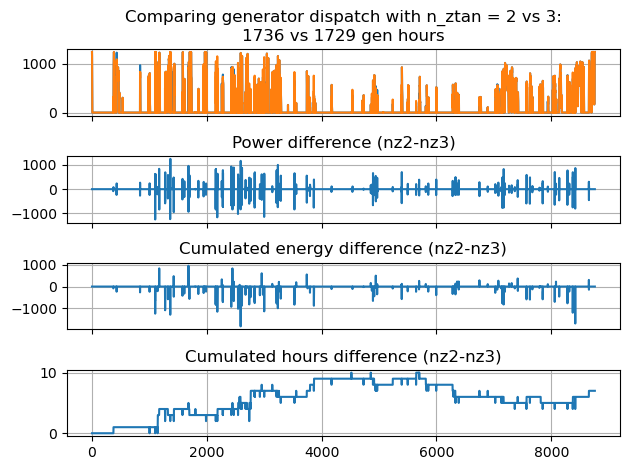

In [100]:
#Pgen_nz2 = value.(model_data["Pgen"]), captured from run with z_tan=[]
#Pgen_nz3 = value.(model_data["Pgen"]), captured from run with z_tan=[0.50]
fig, ax = subplots(4,1, sharex=true)
ax[1].set_title("Comparing generator dispatch with n_ztan = 2 vs 3:\n1736 vs 1729 gen hours");
ax[1].plot(Pgen_nz2)
ax[1].plot(Pgen_nz3)

ax[2].set_title("Power difference (nz2-nz3)")
ax[2].plot(Pgen_nz2 .- Pgen_nz3)

ax[3].set_title("Cumulated energy difference (nz2-nz3)")
ax[3].plot(cumsum(Pgen_nz2) .- cumsum(Pgen_nz3))

ax[4].set_title("Cumulated hours difference (nz2-nz3)")
ax[4].plot(cumsum(Pgen_nz2 .> 1e-6*1246) .- cumsum(Pgen_nz3 .> 1e-6*1246)) # Cumulated hours difference

for axi in ax
    axi.grid(true)
end
fig.tight_layout()